# Analysis of Sensor and Lab samples Raw Datasets

In [4]:
import os
import sys

sys.path.append('..')

import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import scipy.stats as stats

from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance

from utils.functions.normalize_string import normalize_string

In [15]:
local_folder = "/Users/massimilianoarca/Documents/PoliMi/Research Grant/SafeCREW/Data/Tarragona"
utils_folder = os.path.join('..', "utils")

clean_data_folder = os.path.join(local_folder, "Clean Data")

In [ ]:
# import feature mappings
with open(os.path.join(utils_folder, 'mappings', "eb0_features_mapping.json")) as f:
    eb0_features_mapping = json.load(f)
    
with open(os.path.join(utils_folder, 'mappings', "eb1_features_mapping.json")) as f:
    eb1_features_mapping = json.load(f)

# Load Data

In [19]:
eb0_features_lab_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB0_Features_Lab.xlsx")
)

eb0_targets_lab_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB0_Targets_Lab.xlsx")
)

In [20]:
eb1_features_lab_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB1_Features_Lab.xlsx")
)

eb1_targets_lab_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB1_Targets_Lab.xlsx")
)

In [21]:
eb0_sensor_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB0_Sensor.xlsx")
)

In [22]:
eb1_sensor_df = pd.read_excel(
    os.path.join(clean_data_folder, "EB1_Sensor.xlsx")
)

In [23]:
thms_df = pd.read_excel(os.path.join(clean_data_folder, "THMs.xlsx"))

# Lab vs Sensor Data

## EB0

In [24]:
eb0_features_lab_df.columns = [
    normalize_string(c) for c in eb0_features_lab_df.columns
]

eb0_features_mapping = {
    normalize_string(k): v for k, v in eb0_features_mapping.items()
}

### Histograms

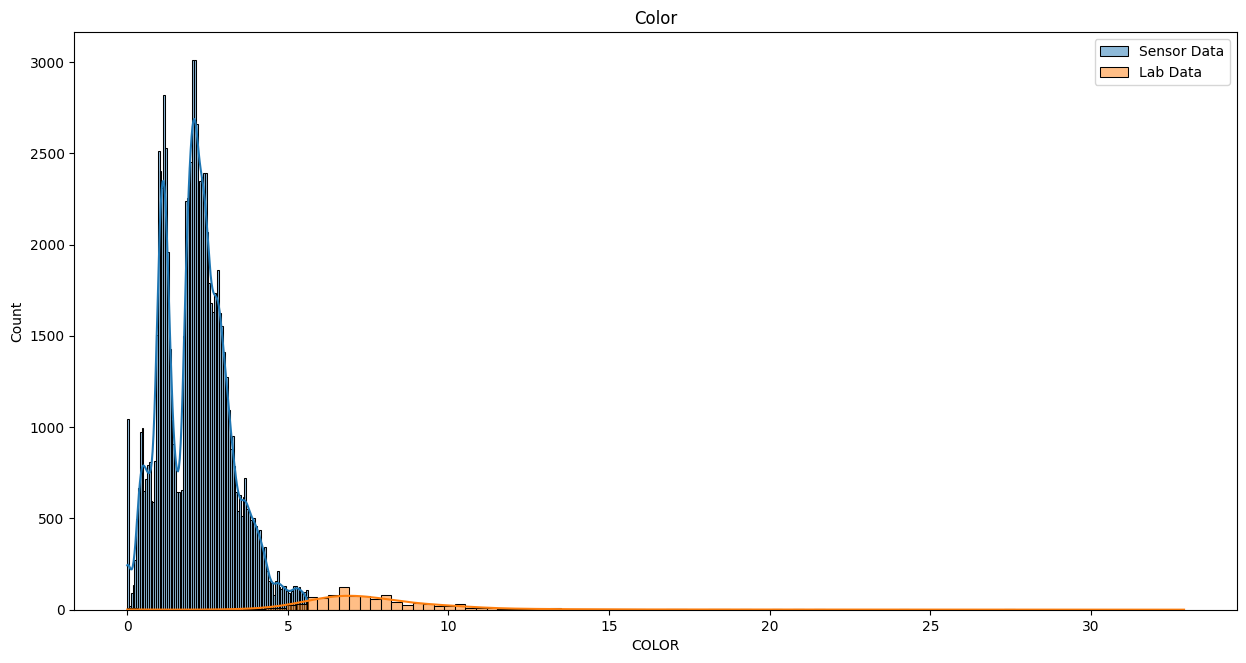

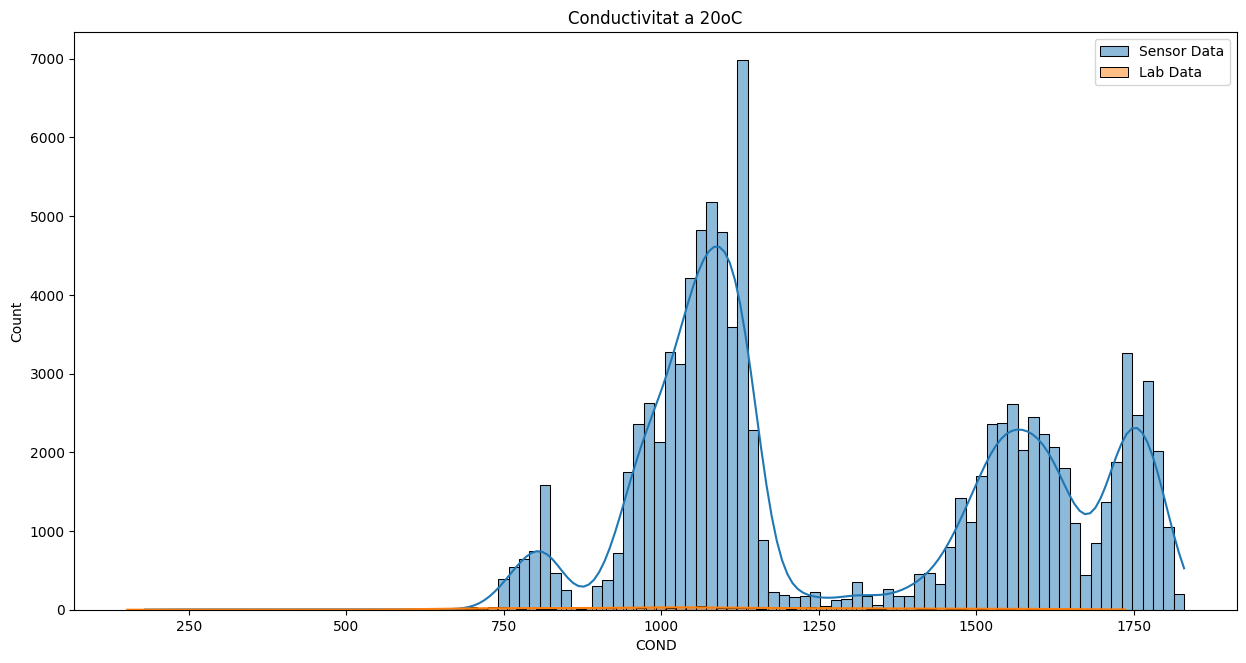

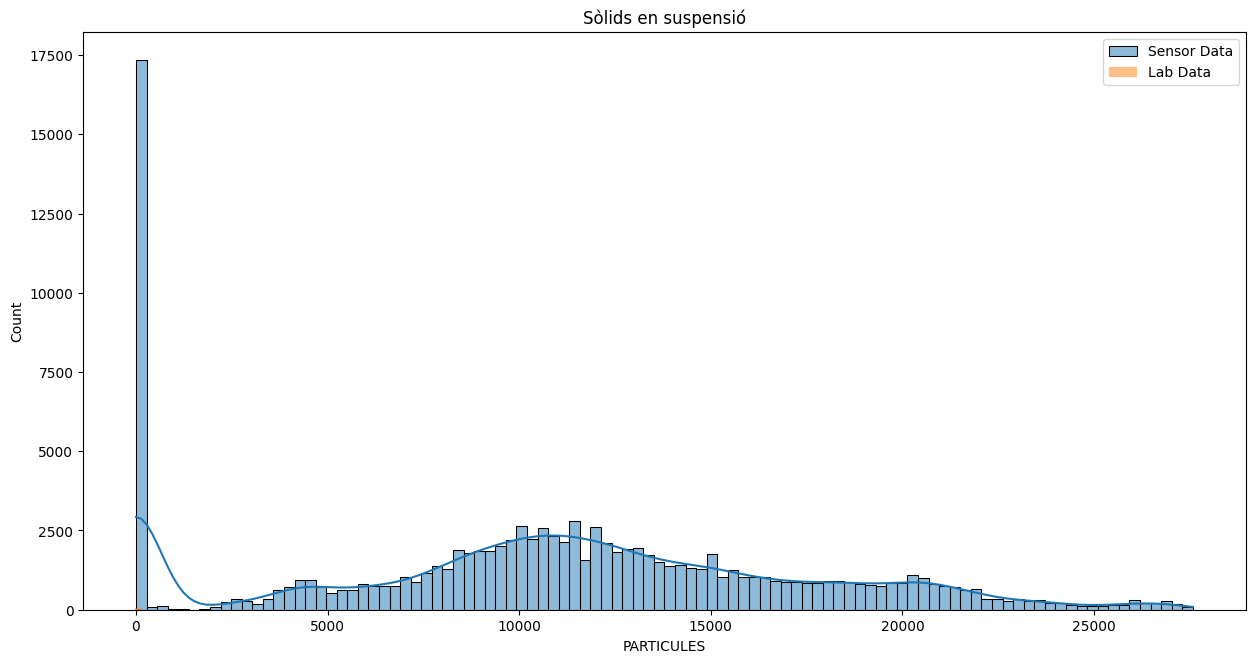

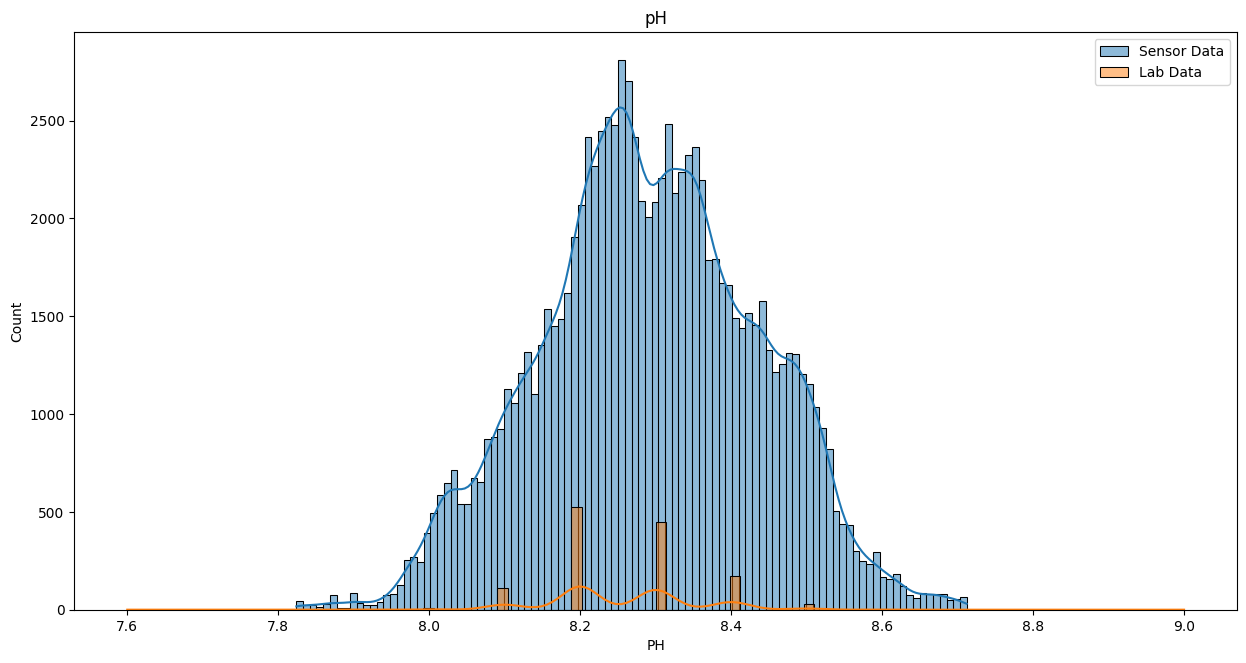

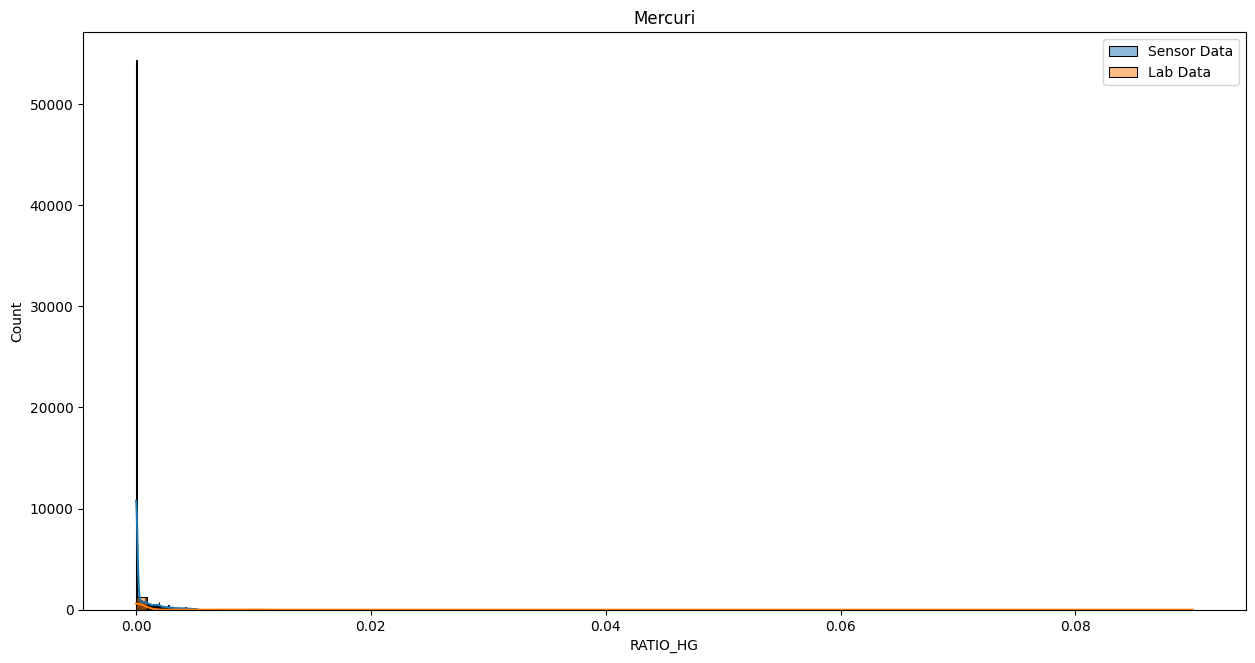

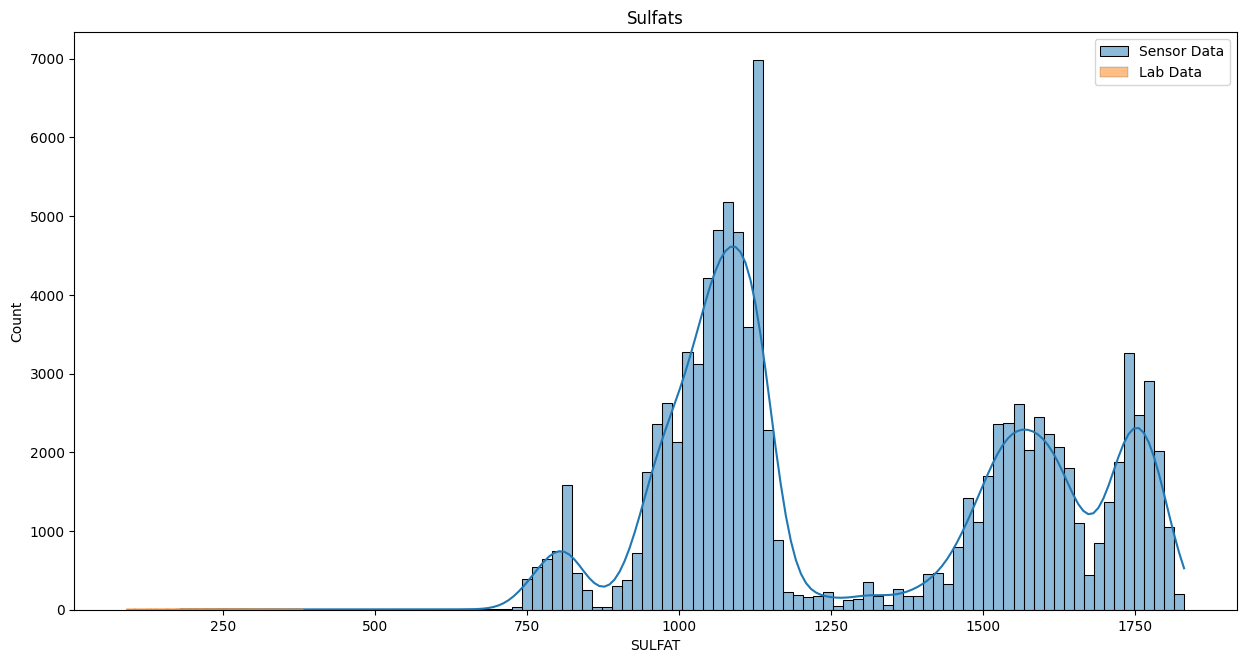

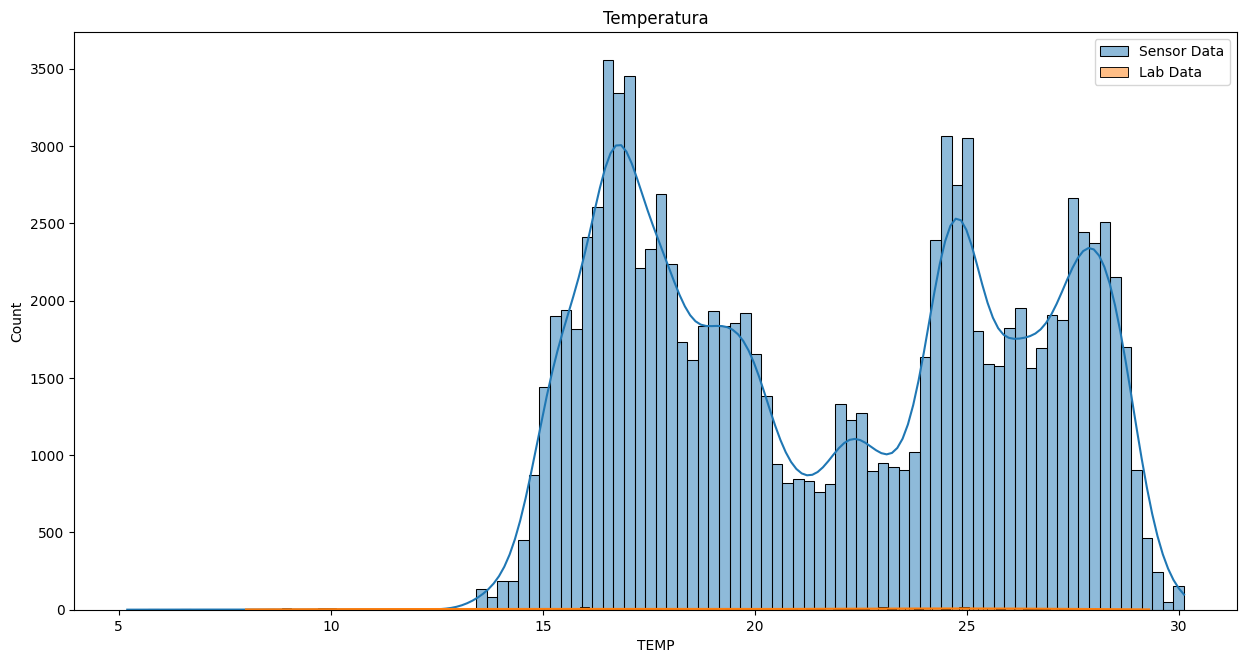

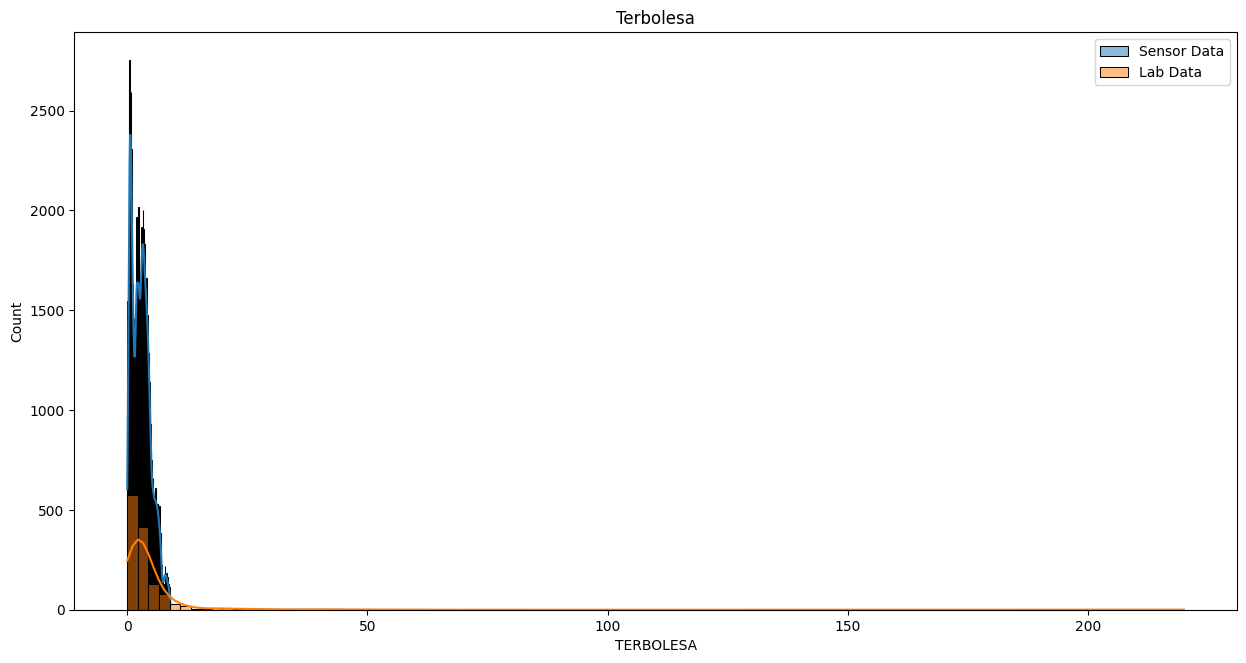

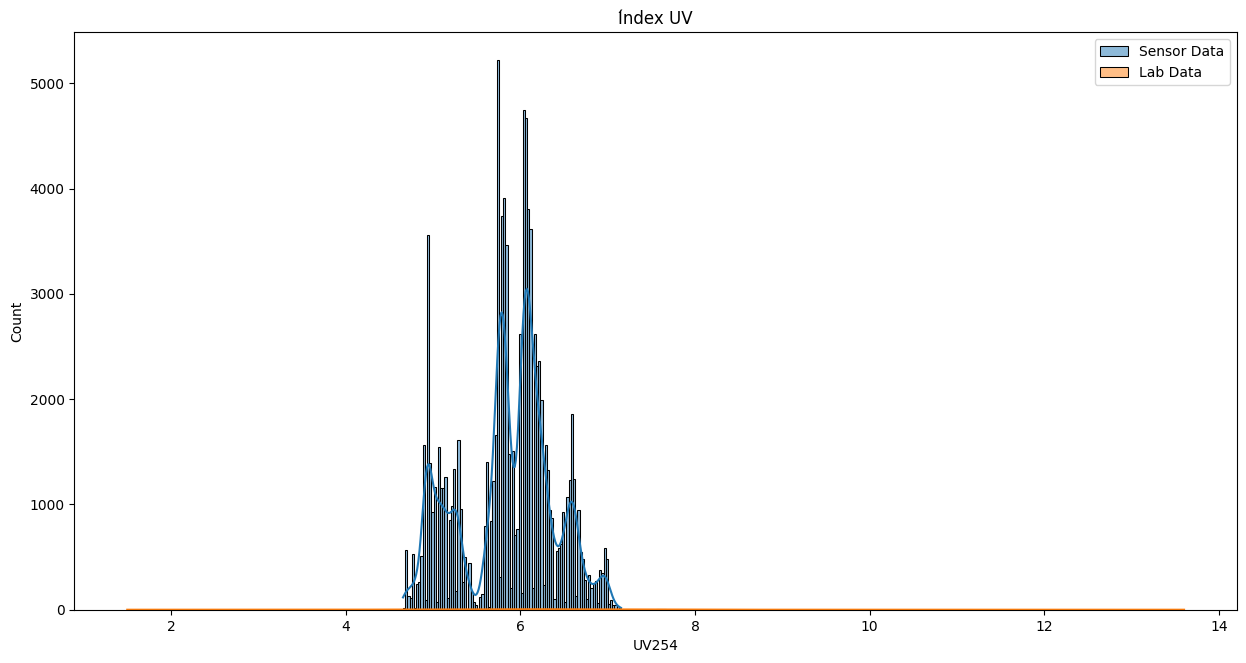

In [64]:
for lab_key, sensor_key in eb0_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb0_features_lab_df[lab_key]
    sensor_df = eb0_sensor_df[sensor_key]

    # remove 0 values from sensor data
    # sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        # counts, bins, patches = plt.hist(
        #     lab_df,
        #     bins=100,
        #     color="blue",
        #     alpha=0.5,
        #     label="Lab",
        #     density=True,
        # )
        # # # Add counts as annotations
        # # for count, bin in zip(counts, bins):
        # #     plt.text(bin, count, str(int(count)))

        # plt.hist(
        #     sensor_df,
        #     bins=100,
        #     color="red",
        #     alpha=0.5,
        #     label="Sensor",
        #     density=True,
        # )

        sns.histplot(
            data=sensor_df,
            kde=True,
            bins=100,
            alpha=0.5,
            stat="count",
            label="Sensor Data",
        )

        sns.histplot(
            data=lab_df, kde=True, bins=100, stat="count", label="Lab Data"
        )

        plt.title(lab_key)
        plt.legend()
        plt.show()

        # The y-axis of a histplot with stat="probability" corresponds
        # to the probability that a value belongs to a certain bar.
        # The sum of the bar heights must be 1.

### Boxplots

In [ ]:
for lab_key, sensor_key in eb0_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb0_features_lab_df[lab_key]
    sensor_df = eb0_sensor_df[sensor_key]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        sns.boxplot(data=[lab_df, sensor_df], palette="Set3")

        plt.title(lab_key)
        plt.show()

### Time series

In [ ]:
for lab_key, sensor_key in eb0_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb0_features_lab_df[["DateTime", lab_key]]
    sensor_df = eb0_sensor_df[["DateTime", sensor_key]]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        sns.lineplot(
            x="DateTime",
            y=lab_key,
            data=lab_df,
            color="blue",
            label="Lab Data",
        )

        sns.lineplot(
            x="DateTime",
            y=sensor_key,
            data=sensor_df,
            color="red",
            label="Sensor Data",
        )

        plt.title(lab_key)
        plt.legend()
        plt.grid(True)
        plt.show()

### Retrieve Common Time Range data + Hypothesis Tests

In [ ]:
ks_hypothesis_tests = {}
t_hypothesis_tests = {}
u_hypothesis_tests = {}

# get common time range samples for lab and sensor data
for lab_key, sensor_key in eb0_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb0_features_lab_df[["DateTime", lab_key]]
    sensor_df = eb0_sensor_df[["DateTime", sensor_key]]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        lab_time_range_df = lab_df[
            (lab_df["DateTime"] >= sensor_df["DateTime"].min())
            & (lab_df["DateTime"] <= sensor_df["DateTime"].max())
        ]

        sensor_time_range_df = sensor_df[
            (sensor_df["DateTime"] >= lab_df["DateTime"].min())
            & (sensor_df["DateTime"] <= lab_df["DateTime"].max())
        ]

        plt.figure(figsize=(15, 7.5))

        sns.lineplot(
            x="DateTime",
            y=lab_key,
            data=lab_time_range_df,
            color="blue",
            label="Lab Data",
        )

        sns.lineplot(
            x="DateTime",
            y=sensor_key,
            data=sensor_time_range_df,
            color="red",
            label="Sensor Data",
        )

        # two sample KS test
        ks_result, ks_p_value = stats.ks_2samp(
            lab_df[lab_key], sensor_df[sensor_key]
        )
        t_result, t_p_value = stats.ttest_ind(
            lab_df[lab_key].dropna(), sensor_df[sensor_key].dropna()
        )
        u_result, u_p_value = stats.mannwhitneyu(
            lab_df[lab_key].dropna(), sensor_df[sensor_key].dropna()
        )

        ks_hypothesis_tests[lab_key] = {
            "ks_test": ks_result,
            "p_value": ks_p_value,
        }

        t_hypothesis_tests[lab_key] = {"t_test": t_result, "p_value": t_p_value}

        u_hypothesis_tests[lab_key] = {"u_test": u_result, "p_value": u_p_value}

        plt.title(lab_key)
        plt.grid(True)
        plt.legend()
        plt.show()

In [ ]:
pd.DataFrame(ks_hypothesis_tests).T

In [ ]:
pd.DataFrame(t_hypothesis_tests).T

In [ ]:
pd.DataFrame(u_hypothesis_tests).T

### Distributions Divergence

In [ ]:
kl_divs = {}
js_divs = {}
tv_dists = {}
w_dists = {}

for lab_key, sensor_key in eb0_features_mapping.items():
    # Compute the probability distribution of the feature in each DataFrame
    lab_df = eb0_features_lab_df[lab_key]
    sensor_df = eb0_sensor_df[sensor_key]

    lab_pdist = np.histogram(lab_df.dropna(), bins=100, density=True)[0]
    sensor_pdist = np.histogram(sensor_df.dropna(), bins=100, density=True)[0]

    # Add a small constant to avoid division by zero
    lab_pdist = lab_pdist + np.finfo(np.float64).eps
    sensor_pdist = sensor_pdist + np.finfo(np.float64).eps

    # Compute divergence metrics
    kl_div = stats.entropy(lab_pdist, sensor_pdist)
    js_div = jensenshannon(lab_pdist, sensor_pdist)
    tv_dist = np.sum(np.abs(lab_pdist - sensor_pdist)) / 2
    w_dist = wasserstein_distance(lab_pdist, sensor_pdist)

    kl_divs[lab_key] = kl_div
    js_divs[lab_key] = js_div
    tv_dists[lab_key] = tv_dist
    w_dists[lab_key] = w_dist


kl_divs = pd.Series(kl_divs)
js_divs = pd.Series(js_divs)
tv_dists = pd.Series(tv_dists)
w_dists = pd.Series(w_dists)

In [ ]:
kl_divs

In [ ]:
js_divs

In [ ]:
tv_dists

In [ ]:
w_dists

## EB1

In [ ]:
eb1_features_lab_df.columns = [
    normalize_string(c) for c in eb1_features_lab_df.columns
]

eb1_features_mapping = {
    normalize_string(k): v for k, v in eb1_features_mapping.items()
}

### Histograms

In [ ]:
for lab_key, sensor_key in eb1_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb1_features_lab_df[lab_key]
    sensor_df = eb1_sensor_df[sensor_key]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        # counts, bins, patches = plt.hist(
        #     lab_df,
        #     bins=100,
        #     color="blue",
        #     alpha=0.5,
        #     label="Lab",
        #     density=True,
        # )
        # # # Add counts as annotations
        # # for count, bin in zip(counts, bins):
        # #     plt.text(bin, count, str(int(count)))

        # plt.hist(
        #     sensor_df,
        #     bins=100,
        #     color="red",
        #     alpha=0.5,
        #     label="Sensor",
        #     density=True,
        # )

        sns.histplot(
            data=sensor_df,
            kde=True,
            bins=100,
            alpha=0.5,
            stat="probability",
            label="Sensor Data",
        )

        sns.histplot(
            data=lab_df,
            kde=True,
            bins=100,
            stat="probability",
            label="Lab Data",
        )

        plt.title(lab_key)
        plt.legend()
        plt.show()

        # The y-axis of a histplot with stat="probability" corresponds
        # to the probability that a value belongs to a certain bar.
        # The sum of the bar heights must be 1.

### Boxplots

In [ ]:
for lab_key, sensor_key in eb1_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb1_features_lab_df[lab_key]
    sensor_df = eb1_sensor_df[sensor_key]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        sns.boxplot(data=[lab_df, sensor_df], palette="Set3")

        plt.title(lab_key)
        plt.show()

### Time series

In [ ]:
for lab_key, sensor_key in eb1_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb1_features_lab_df[["DateTime", lab_key]]
    sensor_df = eb1_sensor_df[["DateTime", sensor_key]]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df[sensor_key] != 0]

    if not lab_df.empty and not sensor_df.empty:
        plt.figure(figsize=(15, 7.5))

        sns.lineplot(
            x="DateTime",
            y=lab_key,
            data=lab_df,
            color="blue",
            label="Lab Data",
        )

        sns.lineplot(
            x="DateTime",
            y=sensor_key,
            data=sensor_df,
            color="red",
            label="Sensor Data",
        )

        plt.title(lab_key)
        plt.legend()
        plt.grid(True)
        plt.show()

### Retrieve Common Time Range data + Hypothesis Tests

In [ ]:
ks_hypothesis_tests = {}
t_hypothesis_tests = {}
u_hypothesis_tests = {}

# get common time range samples for lab and sensor data
for lab_key, sensor_key in eb1_features_mapping.items():
    lab_key = normalize_string(lab_key)
    lab_df = eb1_features_lab_df[["DateTime", lab_key]]
    sensor_df = eb1_sensor_df[["DateTime", sensor_key]]

    # remove 0 values from sensor data
    sensor_df = sensor_df[sensor_df != 0]

    if not lab_df.empty and not sensor_df.empty:
        lab_time_range_df = lab_df[
            (lab_df["DateTime"] >= sensor_df["DateTime"].min())
            & (lab_df["DateTime"] <= sensor_df["DateTime"].max())
        ]

        sensor_time_range_df = sensor_df[
            (sensor_df["DateTime"] >= lab_df["DateTime"].min())
            & (sensor_df["DateTime"] <= lab_df["DateTime"].max())
        ]

        plt.figure(figsize=(15, 7.5))

        sns.lineplot(
            x="DateTime",
            y=lab_key,
            data=lab_time_range_df,
            color="blue",
            label="Lab Data",
        )

        sns.lineplot(
            x="DateTime",
            y=sensor_key,
            data=sensor_time_range_df,
            color="red",
            label="Sensor Data",
        )

        # two sample KS test
        ks_result, ks_p_value = stats.ks_2samp(
            lab_df[lab_key], sensor_df[sensor_key]
        )
        t_result, t_p_value = stats.ttest_ind(
            lab_df[lab_key].dropna(), sensor_df[sensor_key].dropna()
        )
        u_result, u_p_value = stats.mannwhitneyu(
            lab_df[lab_key].dropna(), sensor_df[sensor_key].dropna()
        )

        ks_hypothesis_tests[lab_key] = {
            "ks_test": ks_result,
            "p_value": ks_p_value,
        }

        t_hypothesis_tests[lab_key] = {"t_test": t_result, "p_value": t_p_value}

        u_hypothesis_tests[lab_key] = {"u_test": u_result, "p_value": u_p_value}

        plt.title(lab_key)
        plt.grid(True)
        plt.legend()
        plt.show()

In [ ]:
pd.DataFrame(ks_hypothesis_tests).T

In [ ]:
pd.DataFrame(t_hypothesis_tests).T

In [ ]:
pd.DataFrame(u_hypothesis_tests).T

### Distributions Divergence

In [ ]:
kl_divs = {}
js_divs = {}
tv_dists = {}
w_dists = {}

for lab_key, sensor_key in eb1_features_mapping.items():
    # Compute the probability distribution of the feature in each DataFrame
    lab_df = eb1_features_lab_df[lab_key]
    sensor_df = eb1_sensor_df[sensor_key]

    lab_pdist = np.histogram(lab_df.dropna(), bins=100, density=True)[0]
    sensor_pdist = np.histogram(sensor_df.dropna(), bins=100, density=True)[0]

    # Add a small constant to avoid division by zero
    lab_pdist = lab_pdist + np.finfo(np.float64).eps
    sensor_pdist = sensor_pdist + np.finfo(np.float64).eps

    # Compute divergence metrics
    kl_div = stats.entropy(lab_pdist, sensor_pdist)
    js_div = jensenshannon(lab_pdist, sensor_pdist)
    tv_dist = np.sum(np.abs(lab_pdist - sensor_pdist)) / 2
    w_dist = wasserstein_distance(lab_pdist, sensor_pdist)

    kl_divs[lab_key] = kl_div
    js_divs[lab_key] = js_div
    tv_dists[lab_key] = tv_dist
    w_dists[lab_key] = w_dist


kl_divs = pd.Series(kl_divs)
js_divs = pd.Series(js_divs)
tv_dists = pd.Series(tv_dists)
w_dists = pd.Series(w_dists)

In [ ]:
kl_divs

In [ ]:
js_divs

In [ ]:
tv_dists

In [ ]:
w_dists

# Lab Data Feature-Target Analysis

In [ ]:
trihalometh_columns = [
    "Cloroform",
    "Bromodiclorometà",
    "Dibromoclorometà",
    "Bromoform",
]

acid_columns = [
    "àcid bromocloroacètic",
    "àcid dibromoacètic",
    "àcid dicloroacètic",
    "àcid monobromoacètic",
    "àcid monocloroacètic",
]

other_columns = [
    "Clorat",
    "Clorit",
]

trihalometh_mapping = {
    "Cloroform": "TCM",
    "Bromodiclorometà": "DCBM",
    "Dibromoclorometà": "CDBM",
    "Bromoform": "TBM",
}

## EB1 - THMs

In [ ]:
for eb1_key, thm_key in trihalometh_mapping.items():
    plt.figure(figsize=(15, 7.5))

    lab_df = eb1_targets_lab_df[["DateTime", eb1_key]]
    lab_df = lab_df[lab_df != 0]

    thms = thms_df[["DateTime", thm_key]]

    sns.lineplot(
        x="DateTime", y=eb1_key, data=lab_df, color="blue", label="Lab Data"
    )

    sns.lineplot(x="DateTime", y=thm_key, data=thms, color="red", label="THMs")

    plt.title(eb1_key)
    plt.show()

### Join on same day

In [ ]:
eb1_targets_lab_df

In [ ]:
eb1_features_lab_df

In [ ]:
eb1_features_lab_df["Date"] = eb1_features_lab_df["DateTime"].dt.date
eb1_targets_lab_df["Date"] = eb1_targets_lab_df["DateTime"].dt.date

eb1_lab_df = pd.merge(
    eb1_features_lab_df, eb1_targets_lab_df, on="Date", how="inner"
)

eb1_features_lab_df.drop(columns=["Date"], inplace=True)
eb1_targets_lab_df.drop(columns=["Date"], inplace=True)

In [ ]:
eb1_lab_df

### Join on previous day EB(t-1) -> THMs(t)

In [ ]:
eb1_features_lab_df["Date"] = eb1_features_lab_df["DateTime"].dt.date
eb1_targets_lab_df["Date"] = (
    eb1_targets_lab_df["DateTime"] - pd.Timedelta(days=1)
).dt.date

eb1_lab_df = pd.merge(
    eb1_features_lab_df, eb1_targets_lab_df, on="Date", how="inner"
)

eb1_features_lab_df.drop(columns=["Date"], inplace=True)
eb1_targets_lab_df.drop(columns=["Date"], inplace=True)

In [ ]:
eb1_lab_df

## Correlation Matrix Heatmap

## Hypothesis Tests Correlations

## Scatter Plots

## Boxplots